Thais Lima de Sousa. September, 2016

# Efficient Graph-Based Image Segmentation
## Falzenszwalb and Huttenlocher's algorithm

In [2]:
from vpi.io import *
from vpi.filters import convolve, normalize
import numpy as np
import networkx as nx

In [3]:
# gaussian filter for image smoothing

def create_gauss_kernel(sigma):
    length = int(np.ceil(4*sigma)) + 1
    k = np.zeros((1, length))
    for i in range(length):
        k[0][i] = np.exp(-0.5*np.square(i/sigma))
    k = k / k.sum()

    return k

def smooth(img, sigma):
    if sigma < 0.1:
        return img
    kernel = create_gauss_kernel(sigma)  
    g = convolve(img, kernel)
    g = convolve(g, np.transpose(kernel))
    return g

In [4]:
# disjoint-set forest with union rank and path compression

class UF:
    def __init__(self, n):
        self.num = n
        self.parent = list(range(n))
        self.rank = [0 for i in range(n)]
        self.size = [1 for i in range(n)]
    
    def find(self, v):
        w = v
        while(w != self.parent[w]):
            w = self.parent[w]
        self.parent[v] = w
        return w
    
    def union(self, x, y):
        xR = self.find(x)
        yR = self.find(y)
        if xR == yR:
            return
        
        if self.rank[xR] > self.rank[yR]:
            self.parent[yR] = xR
            self.size[xR] += self.size[yR]
        
        else:
            self.parent[xR] = yR
            self.size[yR] += self.size[xR]
            if self.rank[xR] == self.rank[yR]:
                self.rank[yR] += 1
        self.num -= 1
        
    def sizec(self, x):
        x = self.find(x)
        return self.size[x]
    
    def num_sets(self):
        return self.num
    
    # for debugging
    
    def print_parent(self, x):
        return self.parent[x]
    
    def print_rank(self, x):
        return self.rank[x]

In [5]:
# graph segmentation

def threshold(size, k):
    return k/size

def segment_graph(G, k):
    V = len(G)
    E = G.size()
    c = 1.0*k
    u = UF(V)
    edges = list(G.edges_iter(data='weight'))
    edges.sort(key=lambda w:w[2])
    
    # init thresholdings
    L = [None]*V
    for i in range(V):
        L[i] = threshold(1.0, c)
      
    for i in range(E):
        pedge = edges[i]
        a = u.find(pedge[0])
        b = u.find(pedge[1])
        w = pedge[2]
        if not a == b:
            if w <= L[a] and w <= L[b]:
                u.union(a, b)
                a = u.find(a)
                L[a] = w + threshold(u.sizec(a), c)                
    return u, edges

In [6]:
def diff(r, g, b, x1, y1, x2, y2):
    return np.sqrt(np.square(float(r[x1, y1]) - float(r[x2, y2]))
                  + np.square(float(g[x1, y1]) - float(g[x2, y2]))
                  + np.square(float(b[x1, y1]) - float(b[x2, y2])))


def segment_image(im, sigma, k, min_size):
    r = smooth(im[:,:,0], sigma)
    g = smooth(im[:,:,1], sigma)
    b = smooth(im[:,:,2], sigma)
    

    G = nx.Graph()
    H, W = r.shape[0:2]

    # build weighted edges, 8-connected
    for x in range(H):
        for y in range(W):
            if y < W - 1:
                G.add_edge(x*W + y, x*W + (y+1), weight=diff(r, g, b, x, y, x, y+1))
            if x < H - 1:
                G.add_edge(x*W + y, (x+1)*W + y, weight=diff(r, g, b, x, y, x+1, y))
            if (x < H - 1 and y < W - 1): 
                G.add_edge(x*W + y, (x+1)*W + (y + 1), weight=diff(r, g, b, x, y, x+1, y+1))
            if (y < W - 1 and x > 0): 
                G.add_edge(x*W + y, (x-1)*W + (y + 1), weight=diff(r, g, b, x, y, x-1, y+1))
    
    u, edge_list = segment_graph(G, k)
    
    # post process small components
    for e in edge_list:
        a = u.find(e[0])
        b = u.find(e[1])
        
        if (a != b and ((u.sizec(a) < min_size) or (u.sizec(b) < min_size))):
            u.union(a, b)
        
    num_ccs = u.num_sets()

    # pick random colors for the components
    colors = np.random.uniform(0, 255, 3*H*W).reshape(H*W, 3)
    output = np.zeros((im.shape))
    
    for x in range(H):
        for y in range(W):
            comp = u.find(x*W + y)
            for i in range(3):
                output[x, y, i] = colors[comp, i]
    
    return output, num_ccs   

In [7]:
# read input

def main(img_name, sigma, k, min_size):
    img = read_image(img_name)
    print('Original image:')
    display_image(img)
    # save output and display segmentation
    output, num_css = segment_image(img, sigma, k, min_size)
    print('Found %d components' % num_css)
    display_image(output)

### Results for k = 0 (without image smoothing)

Original image:


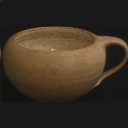

Found 25 components


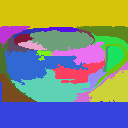

Result from the authors code: 
 Found 25 components


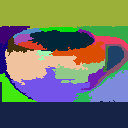

Original image:


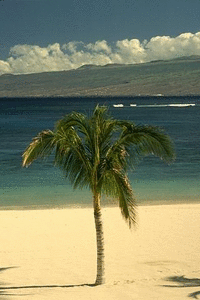

Found 128 components


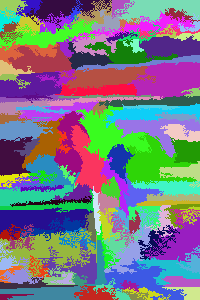

Result from the authors code: 
 Found 128 components


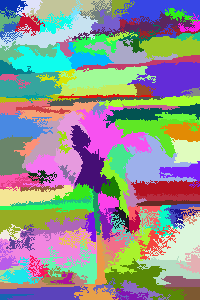

In [8]:
main('images/img1.pnm', 0, 100, 50)
print('Result from the authors code: \n Found 25 components')
img1 = read_image('images/img1-outk0.pnm')
display_image(img1)
main('images/beach.pnm', 0, 300, 100)
print('Result from the authors code: \n Found 128 components')
beach = read_image('images/beach-outk0.pnm')
display_image(beach)

### Results for k > 0 (with image smoothing)

Due to different implementations of the gaussian filter, we get slightly different results:

Original image:


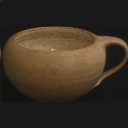

Found 20 components


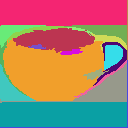

Result from the authors code: 
 Found 22 components


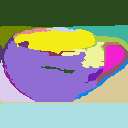

Original image:


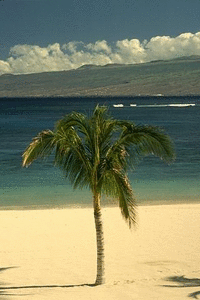

Found 35 components


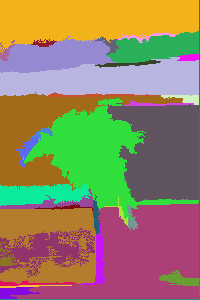

Result from the authors code: 
 Found 33 components


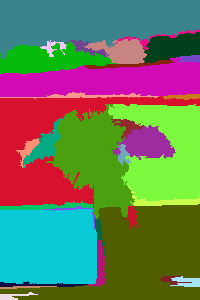

In [9]:
main('images/img1.pnm', 0.5, 100, 50)
print('Result from the authors code: \n Found 22 components')
img1 = read_image('images/img1-outk5.pnm')
display_image(img1)
main('images/beach.pnm', 0.5, 300, 100)
print('Result from the authors code: \n Found 33 components')
beach = read_image('images/beach-outk5.pnm')
display_image(beach)

Original image:


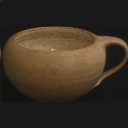

Found 31 components


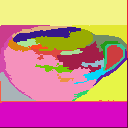

Original image:


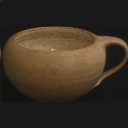

Found 20 components


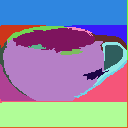

Original image:


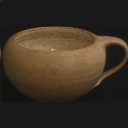

Found 10 components


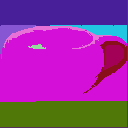

In [15]:
main('images/img1.pnm', 0.5, 50, 50)
main('images/img1.pnm', 0.5, 100, 50)
main('images/img1.pnm', 0.5, 500, 50)

Original image:


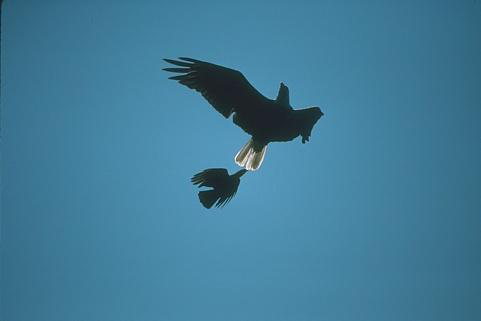

Found 40 components


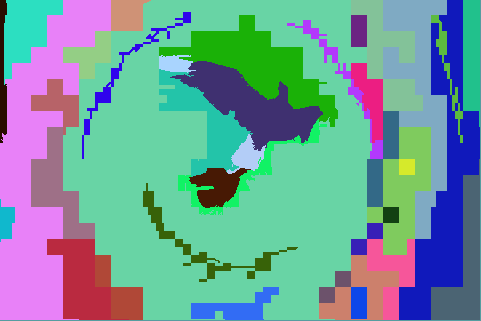

In [23]:
main('../berkeley database/135069.jpg', 0.5, 500, 200)